In [1]:
import os
import gc
import re
import json
import copy
import time
import eli5
import datetime
from numba import jit

from IPython.display import HTML
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
from typing import List, Any

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import random
random.seed(28)
np.random.seed(28)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance

import catboost as cat
from catboost import CatBoostRegressor, CatBoostClassifier

from bayes_opt import BayesianOptimization
import shap

from itertools import product
from functools import partial

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import linear_model
from sklearn.svm import NuSVR, SVR
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error


# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from collections import defaultdict
from joblib import Parallel, delayed

pd.set_option('display.max_columns', 1000)
pd.set_option('max_rows', 500)
pd.options.display.precision = 15
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Objective

- 特徴量を考える。
- アンサンブルについては、最終日周辺で考える。

# Notes

- CV score with added features
    - baseline：0.606055546528173
    - add last_game_round：0.6056430755467688
    - add last_game_level：
    - {world}_duration_sumを除く：

## Load Data

In [2]:
def read_data():
    if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
        data_dir_path = '/kaggle/input/data-science-bowl-2019/'
    else:
        data_dir_path = '../data/raw/'
        
    
    print('Reading train.csv file....')
    train = pd.read_csv(data_dir_path+'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(data_dir_path+'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(data_dir_path+'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(data_dir_path+'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(data_dir_path+'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [3]:
raw_train, raw_test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [4]:
print(raw_train.shape)
raw_train.head()

(11341042, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


## Transform Data

In [5]:
def encode_title(raw_train, raw_test, train_labels):
    train = raw_train.copy()
    test = raw_test.copy()
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
#     activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
#     train['world'] = train['world'].map(activities_world)
#     test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    train['weekday'] = train['timestamp'].dt.weekday
    test['weekday'] = test['timestamp'].dt.weekday
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, list_of_worlds

In [6]:
clip_time = {
    'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
    '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
    'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
    'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
    'Heavy, Heavier, Heaviest':61
}

In [7]:
def parse_game_session(session):
    game_title = session['title'].iloc[-1]
    game_world = session['world'].iloc[-1]
    game_num_correct = session['event_data'].str.contains('"correct":true').astype(int).sum()
    game_num_incorrect = session['event_data'].str.contains('"correct":false').astype(int).sum()
    game_num_trial = game_num_correct + game_num_incorrect
    game_accuracy = game_num_correct/game_num_trial if game_num_trial>0 else -1
    game_num_event_count = session['event_count'].iloc[-1]
    game_session_mean = session['game_time'].diff().mean()
    game_session_std = session['game_time'].diff().std()
    
    return game_title, game_world, game_num_correct, game_num_incorrect, game_num_trial, \
            game_accuracy, game_num_event_count, game_session_mean, game_session_std

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # 学習データとなるリスト（出力値）
    all_assessments = [] 
    
    # installation_idごとの特徴量
    # Constants and parameters declaration
    last_activity = 0
    # typeごとの回数
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    # 最後のセッションの時間
    last_session_time_sec = 0
    last_sessin_world = None
    # 直前のGame_Sessionから得られる特徴量
    last_game_title = None
    last_game_world = None
    last_game_num_correct = 0
    last_game_num_incorrect = 0
    last_game_num_trial = 0
    last_game_accuracy = 0
    last_game_num_event_count = 0
    last_game_session_mean = 0
    last_game_session_std = 0
    # Assessmentから得られる特徴量
    accuracy_groups = {0:0, 1:0, 2:0, 3:0} # accuracy_groupの回数
    accumulated_accuracy_group = 0 # 累積のaccuracy_group。最後にassessmenに挑戦した回数（counter）で割っている。
    accumulated_accuracy = 0 # 累積のaccuracy。単純に正答率を足し合わせている。
    accumulated_correct_attempts = 0 # 累積のcorrect_attempts
    accumulated_uncorrect_attempts = 0 # 累積のuncorrect_attempts
    accumulated_actions = 0 # 全てのセッションにおけるイベント回数
    counter = 0 # Assessmentに挑戦した回数
    time_first_activity = float(user_sample['timestamp'].values[0])
    accumulated_each_world_accuracy: Dict[str, int] = {f'accumulated_accuracy_of_{world}': 0 for world in list_of_worlds}
    # セッション時間の特徴量
    # each session type
    Assessment_durations = []
    clip_durations = [] # clipだけのセッション時間
    Activity_durations = [] # Activityだけのセッション時間
    Game_durations = [] # Gameだけのセッション時間
    world_durations: Dict[str, list] = {world: [] for world in list_of_worlds}
    
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles} # titleごとの最後の正答率
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    game_event_code_count: Dict[str, int] = { str(ev) + '_g': 0 for ev in list_of_event_code}
    Activity_event_code_count: Dict[str, int] = {str(ev) + '_A': 0 for ev in list_of_event_code}    
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    Activity_sum_event_count = 0
    game_sum_event_count = 0
#     game_event_id_count: Dict[str, int] = {eve+'_g': 0 for eve in list_of_event_id}
#     Activity_event_id_count: Dict[str, int] = {eve+'_A': 0 for eve in list_of_event_id}
#     Accessment_event_id_count: Dict[str, int] = {eve+'_ac': 0 for eve in list_of_event_id}
    world_count: Dict[str, int] = {world: 0 for world in list_of_worlds}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_world = session['world'].iloc[0]
        session_title = session['title'].iloc[0]
#         session_game_time = session['game_time'].iloc[-1]
        session_game_time_sec = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
        session_title_text = activities_labels[session_title]
        
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_sum_event_count = Activity_sum_event_count + session['event_count'].iloc[-1]
            Activity_durations.append(session_game_time_sec)
            def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = str(k) + '_A'
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            Activity_event_code_count = update_counters(Activity_event_code_count, "event_code")
#             def update_counters_id(counter: dict, col: str):
#                 num_of_session_count = Counter(session[col])
#                 for k in num_of_session_count.keys():
#                     x = k + '_g'
#                     if col == 'title':
#                         x = activities_labels[k]
#                     counter[x] += num_of_session_count[k]
#                 return counter
#             Activity_event_id_count = update_counters(Activity_event_id_count, "event_id")
        
        if session_type == 'Game':
            # Gameセッションデータを解析
            game_title, game_world, game_num_correct, game_num_incorrect, game_num_trial, \
                game_accuracy, game_num_event_count, game_session_mean, game_session_std = parse_game_session(session)
            
            last_game_title = game_title
            last_game_world = game_world
            last_game_num_correct = game_num_correct
            last_game_num_incorrect = game_num_incorrect
            last_game_num_trial = game_num_trial
            last_game_accuracy = game_accuracy
            last_game_num_event_count = game_num_event_count
            last_game_session_mean = game_session_mean
            last_game_session_std = game_session_std
            
            game_sum_event_count = game_sum_event_count + session['event_count'].iloc[-1]
            Game_durations.append(session_game_time_sec)
            def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = str(k) + '_g'
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            game_event_code_count = update_counters(game_event_code_count, "event_code")
#             def update_counters_id(counter: dict, col: str):
#                 num_of_session_count = Counter(session[col])
#                 for k in num_of_session_count.keys():
#                     x = k + '_g'
#                     if col == 'title':
#                         x = activities_labels[k]
#                     counter[x] += num_of_session_count[k]
#                 return counter
#             game_event_id_count = update_counters(game_event_id_count, "event_id")

        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            
            features.update(game_event_code_count.copy())
#             features.update(game_event_id_count.copy())
            features.update(Activity_event_code_count.copy())
#             features.update(Activity_event_id_count.copy())
#             features.update(Accessment_event_id_count.copy())
            
            features.update(world_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features['installation_session_count'] = sessions_count
            features['hour'] = session['hour'].iloc[-1]
            features['weekday'] = session['weekday'].iloc[-1]
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            features['num_of_post_words'] = sum([v>0 for v in world_count.values()])
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            features['game_sum_event_count'] = game_sum_event_count
            features['Activity_sum_event_count'] = game_sum_event_count
            features.update(accumulated_each_world_accuracy.copy())
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            # TODO: これに合計を入れるとどうなるのだろうか。
            features['Assessment_duration_mean'] = np.mean(Assessment_durations) if len(Assessment_durations)!=0 else 0.0
            features['Assessment_duration_std'] = np.std(Assessment_durations) if len(Assessment_durations)!=0 else 0.0
            features['Clip_duration_mean'] = np.mean(clip_durations) if len(clip_durations)!=0 else 0.0
            features['Clip_duration_std'] = np.std(clip_durations) if len(clip_durations)!=0 else 0.0
            features['Activity_duration_mean'] = np.mean(Activity_durations) if len(Activity_durations)!=0 else 0.0
            features['Activity_duration_std'] = np.std(Activity_durations) if len(Activity_durations)!=0 else 0.0
            features['Game_duration_mean'] = np.mean(Game_durations) if len(Game_durations)!=0 else 0.0
            features['Game_duration_std'] = np.std(Game_durations) if len(Game_durations)!=0 else 0.0
            
            # parse each world durations
            for key, val in world_durations.items():
                features[f'{key}_duration_sum'] = np.sum(val) if len(val)!=0 else 0.0
                features[f'{key}_duration_mean'] = np.mean(val) if len(val)!=0 else 0.0
                features[f'{key}_duration_std'] = np.std(val) if len(val)!=0 else 0.0
                
            # 直前のGame Sessionの特徴量を更新
            features.update({
#                 'last_game_title': last_game_title,
#                 'last_game_world': last_game_world,
                'last_game_num_correct': last_game_num_correct,
                'last_game_num_incorrect': last_game_num_incorrect,
                'last_game_num_trial': last_game_num_trial,
                'last_game_accuracy': last_game_accuracy,
                'last_game_num_event_count': last_game_num_event_count,
                'last_game_session_mean': last_game_session_mean,
                'last_game_session_std': last_game_session_std
            })
                
            Assessment_durations.append(session_game_time_sec)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            accumulated_each_world_accuracy[f'accumulated_accuracy_of_{session_world}'] += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # last session data
            features['last_session_time_sec'] = last_session_time_sec
            features['last_sessin_world'] = last_sessin_world
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)  
            counter += 1
        
        sessions_count += 1
        # World-related features
        world_count[session_world] += 1
        world_durations[session_world].append(session_game_time_sec)
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
        
        last_session_time_sec = session_game_time_sec
        last_sessin_world = session_world
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    
    # worldに関するデータを置換
    map_of_worlds = {w: i for i, w in enumerate(sorted(list_of_worlds))}
    reduce_train['last_sessin_world'] = reduce_train['last_sessin_world'].map(map_of_worlds).fillna(-1).astype(int)
    reduce_test['last_sessin_world'] = reduce_test['last_sessin_world'].map(map_of_worlds).fillna(-1).astype(int)
#     reduce_train['last_game_world'] = reduce_train['last_game_world'].map(map_of_worlds).fillna(-1).astype(int)
#     reduce_test['last_game_world'] = reduce_test['last_game_world'].map(map_of_worlds).fillna(-1).astype(int)

    categoricals = ['session_title', 'last_sessin_world']
    return reduce_train, reduce_test, categoricals

In [9]:
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, \
    activities_labels, assess_titles, list_of_event_id, all_title_event_code, list_of_worlds = encode_title(raw_train, raw_test, train_labels)

# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

0.0026939774600629332


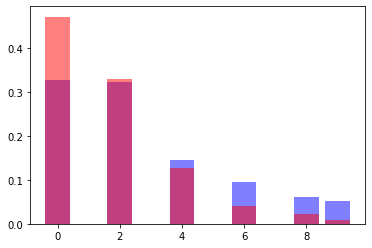

0.0026939774600629332

In [10]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [11]:
# column名をLGBMが扱える形に変更
reduce_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]

In [12]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [13]:
# counter = 0
to_remove = []
# for feat_a in features:
#     for feat_b in features:
#         if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
#             if c > 0.995:
#                 counter += 1
#                 to_remove.append(feat_b)
#                 print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [14]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group']+categoricals:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart_Balancer__Assessment_ -0.04020325710970143 -0.47065833333333335 0.006732930476733109
eb2c19cd 0.17382702091577162 0.008 0.0
0ce40006 0.0008479366873940079 0.0
a8cc6fec 0.0 0.0
bfc77bd6 0.012832108535895986 0.0
01ca3a3c 0.0004522328999434709 0.0
7fd1ac25 0.01978518937252685 0.0
dcb1663e 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
4074bac2 0.0 0.0
6aeafed4 0.14703222159412097 0.008 0.0
2ec694de 0.008988128886376484 0.0
5dc079d8 0.0 0.0
003cd2ee 0.0 0.0
ecc6157f 0.007292255511588468 0.0
13f56524 0.04392312040700961 0.0
119b5b02 0.0002826455624646693 0.0
611485c5 0.0013566986998304127 0.0
17ca3959 0.0 0.0
e4d32835 0.0013001695873374789 0.0
29a42aea 0.004070096099491238 0.0
ab4ec3a4 0.0009044657998869418 0.0
5000_g 0.0 0.0
5010_g 0.0 0.0
4021_g 0.0 0.0
4022_g 0.0 0.0
2010_g 0.0 0.0
2050_A 0.0 0.0
4100_A 0.0 0.0
2060_A 0.0 0.0
4110_A 0.0 0.0
2070_A 0.0 0.0
2075_A 0.0 0.0
2080_A 0.0 0.0
2081_A 0.0 0.0
2083_A 0.0 0.0
3120_A 0.0 0.0
3121_A 0.0 0.0
4220_A 0.0 0.0
4230_A 0.0 0.0
4235_A 0.

In [15]:
categoricals = [x for x in categoricals if x not in (to_exclude + to_remove)]
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 943)

## Training Model

In [16]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [17]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [18]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.oof_pred, self.y_pred, self.score, self.models = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        method = 'StratifiedKFold'
        if method=='StratifiedKFold':
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
            return cv.split(self.train_df, self.train_df[self.target])
        elif method=='GroupKFold':
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df, self.train_df[self.target], self.train_df['installation_id'])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        models = []
        
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            models.append(model)
            
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print(f'\nOur oof cohen kappa score is: {loss_score}\n')
        return oof_pred, y_pred, loss_score, models

In [19]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {
            'n_estimators':5000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'min_data_in_leaf': 50,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'early_stopping_rounds': 100
        }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params    
    
    def get_feature_importance(self, models):
        feature_importance = pd.DataFrame(
            [model.feature_importance() for model in models],
            columns=models[0].feature_name()
        ).T

        feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
        feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
        feature_importance.sort_values(by='Agerage_Importance', inplace=True)
        return feature_importance
    
    def plot_importance(self, models, max_num_features=50, figsize=(12, 15)):
        feature_importance = self.get_feature_importance(models)
        plt.figure(figsize=figsize)
        
        feature_importance[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='Agerage_Importance', xerr='importance_std',
            grid=True, align="center"
        )
        plt.legend()
        plt.show()

In [20]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params
    
    def set_params(self, ps={}):
        return self.get_params()

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | subsam... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.626489	valid_1's rmse: 1.068
Early stopping, best iteration is:
[8]	training's rmse: 0.944371	valid_1's rmse: 1.01152
Partial score of fold 0 is: 0.5732413609638183
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.632133	valid_1's rmse: 1.05894
Early stopping, best iteration is:
[13]	training's rmse: 0.913641	valid_1's rmse: 1.004
Partial score of fold 1 is: 0.584514230674208
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.634342	valid_1's rmse: 1.07201
Early stopping, best iteration is:
[11]	training's rmse: 0.92199	valid_1's rmse: 1.01541
Partial score of fold 2 is: 0.5635789012120558
Training until validation scores don't improve

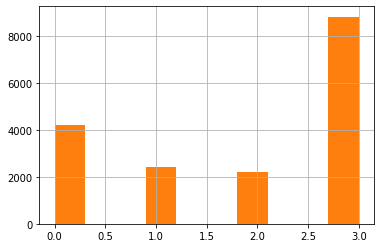

In [21]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals,ps=params)
    print('kappa: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.025, 0.5),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (15, 17),
}

if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
        
    params = LGB_BO.max['params']
    print('\n', LGB_BO.max['params'])
else:
    params = {
        'feature_fraction': 0.5,
        'lambda_l1': 0.5, 
        'lambda_l2': 5, 
        'learning_rate': 0.03, 
        'max_depth': 16, 
        'subsample_freq': 1
    }

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.952885	valid_1's rmse: 1.00901
[200]	training's rmse: 0.893951	valid_1's rmse: 0.991589
[300]	training's rmse: 0.857061	valid_1's rmse: 0.988497
[400]	training's rmse: 0.825996	valid_1's rmse: 0.987507
[500]	training's rmse: 0.799279	valid_1's rmse: 0.987129
Early stopping, best iteration is:
[483]	training's rmse: 0.803566	valid_1's rmse: 0.986901
Partial score of fold 0 is: 0.5875561161516147
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.958648	valid_1's rmse: 1.00077
[200]	training's rmse: 0.898511	valid_1's rmse: 0.980112
[300]	training's rmse: 0.861291	valid_1's rmse: 0.978946
[400]	training's rmse: 0.830448	valid_1's rmse: 0.978824
Early stopping, best iteration is:
[349]	training's rmse: 0.84555	valid_1's rmse: 0.978227
Partial score of fold 1 is: 0.6033023468581908
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.9

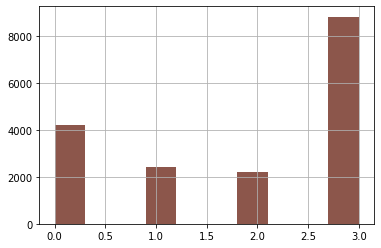

In [22]:
# cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, ps=params)
# xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

<Figure size 864x1440 with 0 Axes>

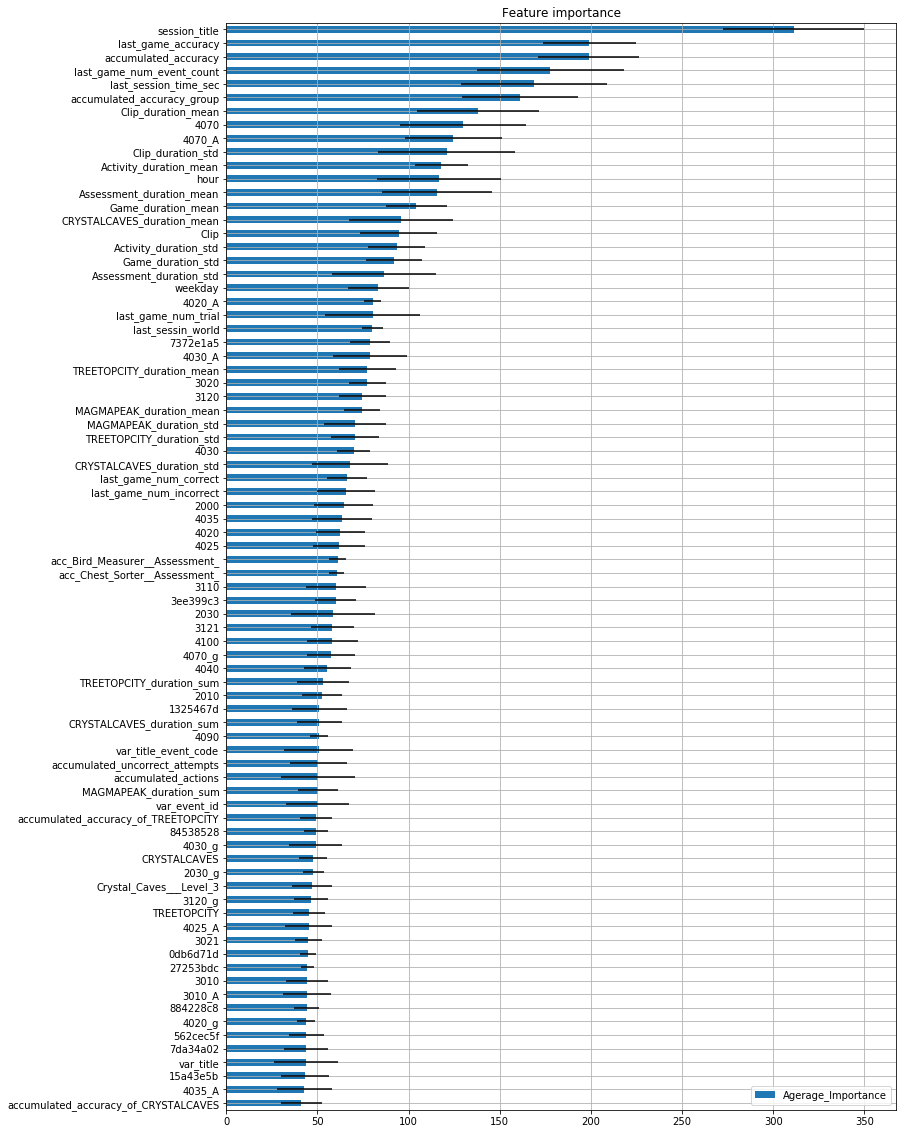

In [23]:
lgb_model.plot_importance(lgb_model.models, max_num_features=80, figsize=(12, 20))

In [24]:
# feature_importances = cat_model.models[0].get_feature_importance()
# feature_names = features
# for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
#     print('{}: {}'.format(name, score))

In [25]:
# fig, ax = plt.subplots(1,1, figsize=(12, 24))
# xgb.plot_importance(xgb_model.models[0], ax=ax, max_num_features=100, importance_type='weight')

In [26]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
# nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

## Submission

In [27]:
weights = {'lbg': 0.70, 'cat': 0.20, 'xgb': 0.10, 'nn': 0.00}

# final_pred = (lgb_model.y_pred * weights['lbg']) + (cat_model.y_pred * weights['cat']) + (xgb_model.y_pred * weights['xgb'])
final_pred = lgb_model.y_pred
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [28]:
# pd.DataFrame(
#     [(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) 
#          for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)],
#     columns=['lgb', 'cat', 'xgb', 'nn']
# ).head(50)

In [29]:
# improved
import scipy as sp
from functools import partial

from sklearn.metrics import cohen_kappa_score

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, num_class=4):
        self.coef_ = 0
        self.initial_coef = [0.5+i for i in range(num_class-1)]
        self.labels = [i for i in range(num_class)]
    
    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = self.initial_coef
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return preds
    
    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']


rmse_score is 0.979997569525652


off_score is 0.6026086449981174



0    0.174
1    0.137
2    0.235
3    0.454
Name: accuracy_group, dtype: float64

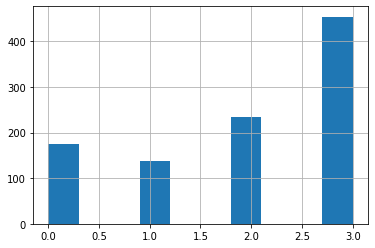

In [30]:
trian_pred_reg = lgb_model.oof_pred

optR = OptimizedRounder(num_class=4)
optR.fit(trian_pred_reg, reduce_train['accuracy_group'])
coefficients = optR.coefficients()

opt_preds = optR.predict(trian_pred_reg.reshape(-1, ), coefficients)

from sklearn.metrics import mean_squared_error
rmse_score = np.sqrt(mean_squared_error(reduce_train['accuracy_group'], lgb_model.oof_pred))
print(f'\nrmse_score is {rmse_score}\n')

off_score = cohen_kappa_score(reduce_train['accuracy_group'], opt_preds, weights='quadratic')
print(f'\noff_score is {off_score}\n')

sample_submission['accuracy_group'] = optR.predict(final_pred.reshape(-1, ), coefficients).astype(int)
sample_submission.to_csv('submission.csv', index=False)
display(sample_submission['accuracy_group'].value_counts(normalize=True).sort_index())
sample_submission['accuracy_group'].hist()

In [31]:
from sklearn.model_selection import train_test_split


smpl_scores = []
valid_scores = []
for i in range(100):
    _trian, _smpl_train, _pred, _smpl_pred = train_test_split(\
        reduce_train['accuracy_group'], opt_preds, test_size=0.14, random_state=42+i)
    
    smpl_scores.append(cohen_kappa_score(_smpl_train, _smpl_pred, weights='quadratic'))
    valid_scores.append(cohen_kappa_score(_trian, _pred, weights='quadratic'))

pd.DataFrame({'smpl': smpl_scores, 'valid': valid_scores}).describe().round(3)

,smpl,valid
count,100.000,100.000
mean,0.601,0.603
std,0.014,0.002
min,0.571,0.597
25%,0.591,0.601
50%,0.601,0.603
75%,0.612,0.605
max,0.637,0.608
